# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                                std=[0.20, 0.20, 0.20])
                       ])
                       )
data_test = dset.SVHN('./data/', split='test',
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                               std=[0.20, 0.20, 0.20])
                      ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)


# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [18]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()  # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += float(torch.sum(indices == y))
            total_samples += float(y.shape[0])
            loss_accum += float(loss_value)

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if scheduler is not None:
            scheduler.step(ave_loss)
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()  # Evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
            prediction = torch.argmax(model(x), 1)
            for i in range(len(prediction)):
                if prediction[i] == y[i]:
                    correct += 1
            total += len(prediction)

    return float(correct / total)


loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.802825, Train accuracy: 0.419769, Val accuracy: 0.599481
Average loss: 1.387077, Train accuracy: 0.621575, Val accuracy: 0.670807
Average loss: 1.292993, Train accuracy: 0.668157, Val accuracy: 0.688827


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.183372, Train accuracy: 0.195799, Val accuracy: 0.224831
Average loss: 2.045876, Train accuracy: 0.250759, Val accuracy: 0.279298
Average loss: 1.908096, Train accuracy: 0.324489, Val accuracy: 0.395195
Average loss: 1.745361, Train accuracy: 0.407160, Val accuracy: 0.427343
Average loss: 1.690538, Train accuracy: 0.428847, Val accuracy: 0.439902


Добавьте слой с Batch Normalization

In [12]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
    nn.BatchNorm1d(10),
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.238356, Train accuracy: 0.696789, Val accuracy: 0.725411
Average loss: 1.801838, Train accuracy: 0.422005, Val accuracy: 0.596956
Average loss: 1.396545, Train accuracy: 0.618162, Val accuracy: 0.678588
Average loss: 1.300091, Train accuracy: 0.665256, Val accuracy: 0.708689
Average loss: 1.252912, Train accuracy: 0.688616, Val accuracy: 0.721589
Average loss: 1.220297, Train accuracy: 0.707624, Val accuracy: 0.745205
Average loss: 1.791337, Train accuracy: 0.428608, Val accuracy: 0.588083
Average loss: 1.411503, Train accuracy: 0.611934, Val accuracy: 0.662139
Average loss: 1.316302, Train accuracy: 0.662560, Val accuracy: 0.697973
Average loss: 1.264440, Train accuracy: 0.687165, Val accuracy: 0.698587
Average loss: 1.231283, Train accuracy: 0.701856, Val accuracy: 0.709576


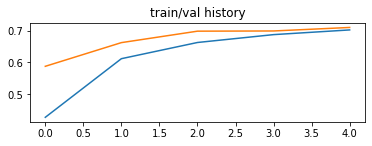

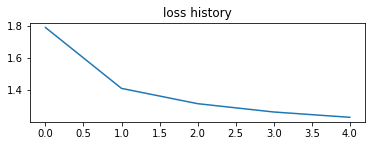

In [16]:
plt.subplot(211)
plt.plot(train_history)
plt.plot(val_history)
plt.title("train/val history")
plt.show()
plt.subplot(212)
plt.plot(loss_history)
plt.title("loss history")
plt.show()

Добавьте уменьшение скорости обучения по ходу тренировки.

In [19]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little too!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
    nn.BatchNorm1d(10),
)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10,
                                                       scheduler)

Average loss: 1.825632, Train accuracy: 0.403423, Val accuracy: 0.570268
Average loss: 1.418292, Train accuracy: 0.604426, Val accuracy: 0.639547
Average loss: 1.316674, Train accuracy: 0.659250, Val accuracy: 0.671558
Average loss: 1.259634, Train accuracy: 0.688598, Val accuracy: 0.715446
Average loss: 1.222131, Train accuracy: 0.706617, Val accuracy: 0.730530
Average loss: 1.196400, Train accuracy: 0.718834, Val accuracy: 0.724660
Average loss: 1.171563, Train accuracy: 0.731649, Val accuracy: 0.735172
Average loss: 1.152629, Train accuracy: 0.738235, Val accuracy: 0.716879
Average loss: 1.134981, Train accuracy: 0.745777, Val accuracy: 0.727186
Average loss: 1.116950, Train accuracy: 0.752107, Val accuracy: 0.752235


In [ ]:
plt.subplot(211)
plt.plot(train_history)
plt.plot(val_history)
plt.title("train/val history")
plt.show()
plt.subplot(212)
plt.plot(loss_history)
plt.title("loss history")
plt.show()

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [22]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)


def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval()  # Evaluation mode
    with torch.no_grad():
        for i_step, (x, y) in enumerate(
                torch.utils.data.DataLoader(dataset, batch_size=len(indices), sampler=SubsetSampler(indices))):
            predictions = torch.argmax(model(x), 1)
            ground_truth = y

    return predictions.numpy(), ground_truth.numpy()


# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

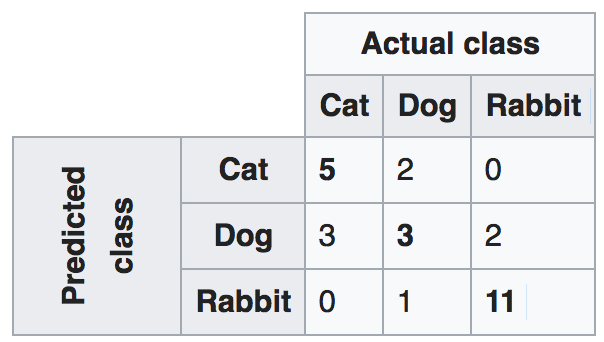

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

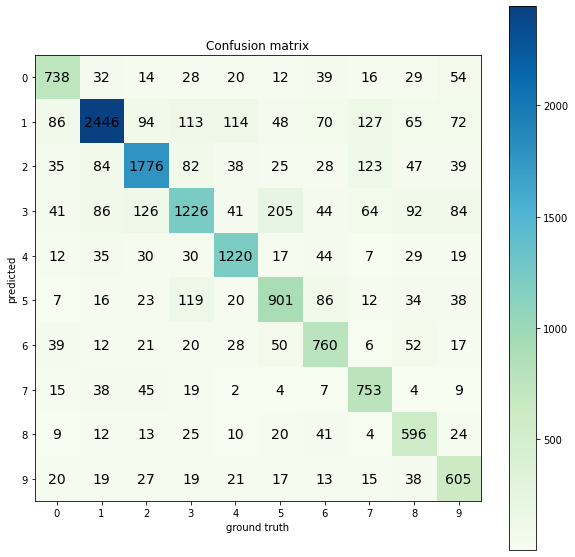

In [24]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10, 10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')


def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """

    confusion_matrix = np.zeros((10, 10), int)
    for i in range(predictions.shape[0]):
        confusion_matrix[predictions[i]][ground_truth[i]] += 1
    return confusion_matrix


confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

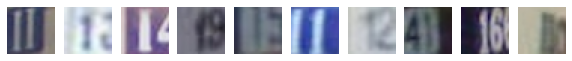

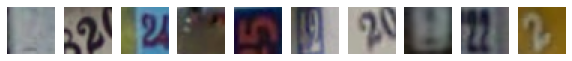

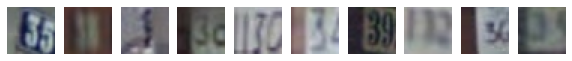

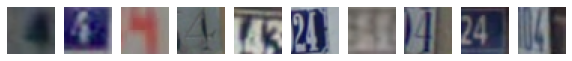

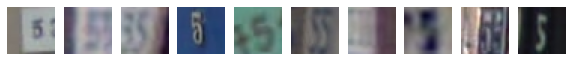

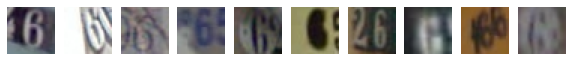

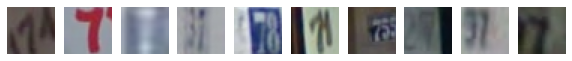

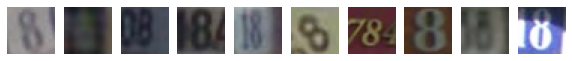

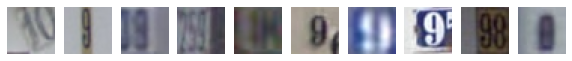

In [25]:
data_train_images = dset.SVHN('./data/', split='train')


def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10, 1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1, to_show, i + 1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)


def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    images_indecies = np.where((predictions == predicted_class) & (groud_truth == gt_class))
    visualize_images(val_indices[images_indecies], data)


visualize_predicted_actual(1, 1, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 2, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 3, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 4, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 5, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 6, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 9, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [27]:
# Experiment here!
print("Model_I")
Model_I = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
    nn.BatchNorm1d(10),
)
optimizer = optim.SGD(Model_I.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)
loss_history, train_history, val_history = train_model(Model_I, train_loader, val_loader, loss, optimizer, 40,
                                                       scheduler)
print("Model_II")
Model_II = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
    nn.BatchNorm1d(10),
)
optimizer = optim.SGD(Model_II.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
loss_history, train_history, val_history = train_model(Model_II, train_loader, val_loader, loss, optimizer, 40,
                                                       scheduler)
print("Model_III")
Model_III = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
    nn.BatchNorm1d(10),
)
optimizer = optim.SGD(Model_III.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
loss_history, train_history, val_history = train_model(Model_III, train_loader, val_loader, loss, optimizer, 40,
                                                       scheduler)


Model_I
Average loss: 1.768984, Train accuracy: 0.439580, Val accuracy: 0.618388
Average loss: 1.404476, Train accuracy: 0.628041, Val accuracy: 0.686233
Average loss: 1.325748, Train accuracy: 0.670819, Val accuracy: 0.690192
Average loss: 1.287055, Train accuracy: 0.692796, Val accuracy: 0.717016
Average loss: 1.266253, Train accuracy: 0.708596, Val accuracy: 0.738653
Average loss: 1.253181, Train accuracy: 0.715916, Val accuracy: 0.741178
Average loss: 1.241452, Train accuracy: 0.724840, Val accuracy: 0.715787
Average loss: 1.233022, Train accuracy: 0.728628, Val accuracy: 0.737356
Average loss: 1.226514, Train accuracy: 0.734515, Val accuracy: 0.757559
Average loss: 1.223366, Train accuracy: 0.738098, Val accuracy: 0.751416
Average loss: 1.216759, Train accuracy: 0.741272, Val accuracy: 0.747526
Average loss: 1.213359, Train accuracy: 0.742313, Val accuracy: 0.756604
Average loss: 1.205279, Train accuracy: 0.745521, Val accuracy: 0.741656
Average loss: 1.202005, Train accuracy: 0.7

In [29]:
Model_IV = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10))
Model_IV.type(torch.FloatTensor)
optimizer = optim.Adam(Model_IV.parameters(), lr=1e-3, weight_decay=1e-4)
loss_history_4, train_history_4, val_history_4 = train_model(Model_IV, train_loader, val_loader, loss, optimizer, 40)

Average loss: 1.407225, Train accuracy: 0.559857, Val accuracy: 0.682547
Average loss: 1.017252, Train accuracy: 0.689639, Val accuracy: 0.729848
Average loss: 0.897876, Train accuracy: 0.726752, Val accuracy: 0.759743
Average loss: 0.815972, Train accuracy: 0.749701, Val accuracy: 0.766023
Average loss: 0.769813, Train accuracy: 0.763505, Val accuracy: 0.787660
Average loss: 0.729066, Train accuracy: 0.773709, Val accuracy: 0.793188
Average loss: 0.695600, Train accuracy: 0.785193, Val accuracy: 0.807931
Average loss: 0.672608, Train accuracy: 0.792700, Val accuracy: 0.810866
Average loss: 0.655362, Train accuracy: 0.795857, Val accuracy: 0.793256
Average loss: 0.640551, Train accuracy: 0.800140, Val accuracy: 0.793393
Average loss: 0.623888, Train accuracy: 0.805941, Val accuracy: 0.811480
Average loss: 0.612047, Train accuracy: 0.808910, Val accuracy: 0.821104
Average loss: 0.597867, Train accuracy: 0.813773, Val accuracy: 0.812436
Average loss: 0.592107, Train accuracy: 0.814678, V

In [32]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy_1 = compute_accuracy(Model_I, test_loader)
test_accuracy_2 = compute_accuracy(Model_II, test_loader)
test_accuracy_3 = compute_accuracy(Model_III, test_loader)
print("Test accuracy for Model_I: %2.4f" % test_accuracy_1)
print("Test accuracy for Model_II: %2.4f" % test_accuracy_2)
print("Test accuracy for Model_III: %2.4f" % test_accuracy_3)

Test accuracy for Model_I: 0.7553
Test accuracy for Model_II: 0.7719
Test accuracy for Model_III: 0.7764


In [33]:
test_accuracy_4 = compute_accuracy(Model_IV, test_loader)
print("Test accuracy for Model_IV: %2.4f" % test_accuracy_4)

Test accuracy for Model_IV: 0.8213


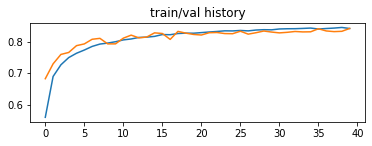

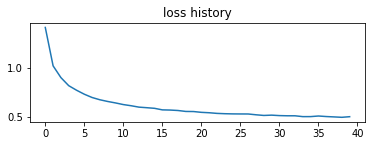

In [34]:
plt.subplot(211)
plt.plot(train_history_4)
plt.plot(val_history_4)
plt.title("train/val history")
plt.show()
plt.subplot(212)
plt.plot(loss_history_4)
plt.title("loss history")
plt.show()